# TP Final Integrador Visión por Computadora II - CEIA - FIUBA - Cohorte 16

Alumnos: Fabricio Lopretto (a1616) y Santiago José Olaciregui (a1611)

## Implementación de Red YOLO para la detección de objetos: Conjunto de Entrenamiento Preprocesado.

### Objetivos:

Realizar el entrenamiento (train) y la prueba (test) de una red neuronal de detección de objetos sobre un dataset de imagenes de cartas del juego de mesa UNO.

Se busca la generación de artefactos que permitan analizar la diferencia de desempeño de la red al utilizar el conjunto de datos de entrenamiento con y sin preprocesamiento.

### Características:

En esta notebook, se utiliza el mismo conjunto de entrenamiento que en la notebook "YOLO+RGB", pero al que se le realizo el preporcesamiento definido en la notebbok "data_engineering".

A modo de recordatorio, en la misma, se realizaron varios expermientos aplicando varios filtros al conjunto de datos. De ellos, resultó un conjunto de datos preprocesados en los que se aplicó un desenfoque sobre el fondo manteniendo enfocado el objeto, con la intención de resaltar bordes de estos y failitar su detección.


In [1]:
# Instala los modulos necesarios
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install requests beautifulsoup4
!pip3 install torch torchvision torchaudio
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 23.9 MB/s eta 0:00:00


In [2]:
# Importa las librerias necesarias
from google.colab import drive
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from IPython.display import display
from pathlib import Path
from ultralytics import YOLO
import os

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
import torchvision.transforms as transforms

import tensorflow as tf

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Ejemplo del conjunto de datos utilizado

In [6]:
# URL de la carpeta en el repositorio de GitHub (no la URL raw)
url = "https://github.com/fabriciolopretto/VpC2/tree/main/data/data_procesada/train_mask_background/images/"

# Realiza la solicitud y analiza el HTML
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Lista para almacenar URLs de las imágenes
image_urls = []

# Encuentra todas las etiquetas 'a' que enlacen a imágenes
for link in soup.find_all('a', href=True):
    href = link['href']
    if href.endswith(('.jpg', '.png', '.jpeg', '.gif')):  # Filtra por tipos de imagen
        # Construye la URL de la imagen en bruto
        raw_url = f"https://raw.githubusercontent.com{href.replace('/blob', '')}"
        image_urls.append(raw_url)

# Imprime o usa la lista de URLs de imágenes
print("URLs de las imágenes:")
for img_url in image_urls:
    print(img_url)


URLs de las imágenes:
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_procesada/train_mask_background/images/000244709_jpg.rf.6ad3fbffe1283e6d8f48a207aecfb9cd.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_procesada/train_mask_background/images/000244709_jpg.rf.6ad3fbffe1283e6d8f48a207aecfb9cd.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_procesada/train_mask_background/images/000390579_jpg.rf.ecc8f1090e6d61590576896ba79f5a3c.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_procesada/train_mask_background/images/000390579_jpg.rf.ecc8f1090e6d61590576896ba79f5a3c.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_procesada/train_mask_background/images/000413060_jpg.rf.c6da079ccf2c5b108ef52301919c5576.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_procesada/train_mask_background/images/000413060_jpg.rf.c6da079ccf2c5b108ef52301919c557

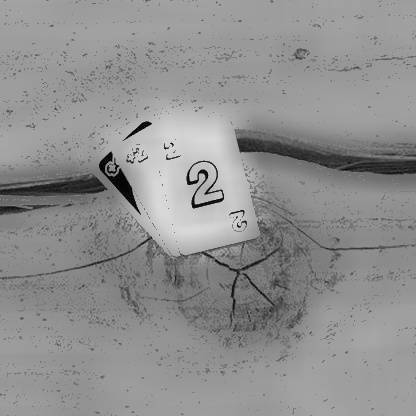

In [7]:
# Muestra la primera imagen del dataset a modo de prueba
url = image_urls[0]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

In [8]:
# Clona el repositorio de GitHub con los conjuntos de datos
!git clone https://github.com/fabriciolopretto/VpC2.git

Cloning into 'VpC2'...
remote: Enumerating objects: 24305, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 24305 (delta 0), reused 0 (delta 0), pack-reused 24304 (from 1)
Receiving objects: 100% (24305/24305), 674.49 MiB | 31.70 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (30583/30583), done.


## Red Neuronal YOLO

### Ejecución del modelo:

**1. Carga del modelo YOLOv8.** Se utiliza un modelo preentrenado (weights inicializados) basado en la arquitectura YOLOv8n. En el código, cuando se instancia el modelo con YOLO(MODEL_NAME) (donde MODEL_NAME = "yolov8n"), el framework carga automáticamente los pesos preentrenados en el dataset COCO. Estos pesos contienen conocimiento general que el modelo ha aprendido, como la capacidad de detectar bordes, esquinas, y formas básicas. COCO incluye clases como "números" o "carteles", que comparten similitudes con los números en las cartas UNO. Luego, durante el entrenamiento con el nuevo dataset, los pesos del modelo se ajustan gradualmente para adaptarse al dataset específico de las cartas del juego UNO. Las primeras capas (cercanas a la entrada) se ajustan poco o nada, porque representan características genéricas (como bordes o texturas).Las últimas capas (cercanas a la salida) se reentrenan para reconocer las características y clases específicas de las cartas. El modelo se ajusta para reconocer los números y posiblemente las características únicas de las cartas UNO (formas, colores, texturas).

**2. Data Augumentation.** Se aplica automáticamente para enriquecer las muestras de entrenamiento. Entre las operaciones realizadas se tiene escalado manteniendo las proporciones, rotación en un rango de ángulos, recorte aleatorio de partes de las imagenes, traslación dentro del dominio de la imagen, ajuste de brillo, saturación y de contraste, introducción de ruido y mezcla de imagenes. Además, cada lote de entrenamiento recibe transformaciones únicas. No todas las operaciones se aplican a cada imagen; hay una probabilidad definida para cada una (por ejemplo, un 50% para rotaciones o un 30% para cambios de brillo).

**3. Workers.** Procesos en paralelo (4) para acelerar el preprocesamiento de datos.

**4. Evaluación.** Se evalúa el modelo en el conjunto de prueba definido en el archivo YAML. Para esto, utiliza métricas como mAP@50 (precisión promedio para un umbral de IoU: Intersection over Union) y/o mAP@50-95 como (precisión promedio en un rango de umbrales 50% a 95%).

**5. Resultados**: Los resultados (pesos entrenados, gráficos de pérdida, métricas) se guardan en el directorio runs/detect/UNO_detection.

In [9]:
# -----------------------------
# Configuración inicial
# -----------------------------
# Directorios del dataset (rutas locales después de clonar el repositorio)
DATASET_DIR = "/content/VpC2/"  # Ruta del repositorio clonado en Google Colab
TRAIN_IMAGES_DIR = os.path.join(DATASET_DIR, "data/data_procesada/train_mask_background/images/")
TRAIN_LABELS_DIR = os.path.join(DATASET_DIR, "data/data_procesada/train_mask_background/labels/")
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "data/data_original/test/images/")
TEST_LABELS_DIR = os.path.join(DATASET_DIR, "data/data_original/test/labels/")

# Archivo de configuración de datos para YOLOv8 (con rutas locales)
DATA_YAML = """
train: /content/VpC2/data/data_procesada/train_mask_background/images/
val: /content/VpC2/data/data_original/test/images/

nc: 15  # Número de clases
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
"""

# Guarda el archivo YAML
DATA_YAML_PATH = Path(DATASET_DIR) / "data.yaml"
with open(DATA_YAML_PATH, "w") as file:
    file.write(DATA_YAML)

print(f"Archivo YAML guardado en: {DATA_YAML_PATH}")

# Hiperparámetros del entrenamiento
MODEL_NAME = "yolov8n"  # Arquitectura (nano, pequeña para este caso)
EPOCHS = 50
BATCH_SIZE = 16
IMAGE_SIZE = 416

# -----------------------------
# Entrenamiento
# -----------------------------
def train_yolov8():
    """
    Entrena un modelo YOLOv8 en el dataset proporcionado.

    Se carga un modelo preentrenado de YOLOv8 utilizando la arquitectura especificada.
    El modelo se entrena utilizando los datos definidos en el archivo YAML.
    Se definen los parámetros del entrenamiento.
    El número de workers (procesos que trabajan en paralelo) se establece en 4.
    Se realiza DA utiliando el pipeline de YOLO.
    El nombre del directorio donde se guardarán los resultados se define como "UNO_detection".
    """
    print("Iniciando entrenamiento YOLOv8...")
    model = YOLO(MODEL_NAME)
    model.train(
        data=str(DATA_YAML_PATH),
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMAGE_SIZE,
        workers=4,
        augment=True,
        name="UNO_detection"
    )
    print("Entrenamiento finalizado.")


# -----------------------------
# Evaluación
# -----------------------------
def evaluate_yolov8():
    """
    Evalua el modelo YOLOv8 en el conjunto de prueba.

    Se carga el mejor modelo entrenado desde el directorio de resultados.
    Se realiza la evaluación utilizando el conjunto de test especificado en el archivo YAML.
    El resultado de la evaluación incluye dos métricas comunes de precisión para
    modelos de detección de objetos: mAP@50 (mean Average Precision a 50% de IoU)
    y mAP@50-95 (mean Average Precision en varios umbrales de IoU).
    """
    print("Evaluando el modelo YOLOv8...")
    model = YOLO(f"runs/detect/UNO_detection/weights/best.pt")
    results = model.val(data=str(DATA_YAML_PATH), imgsz=IMAGE_SIZE)
    print(f"mAP@50: {results.box.map50:.4f}, mAP@50-95: {results.box.map:.4f}")


# -----------------------------
# Predicción
# -----------------------------
def predict_yolov8(image_path):
    """
    Realiza predicciones en una imagen usando el modelo entrenado.

    Se carga el mejor modelo entrenado (best.pt).
    Se realiza la predicción sobre la imagen especificada.
    Se establece un umbral de confianza (conf=0.25), lo que significa que solo se
    considerarán las predicciones con una probabilidad superior al 25%.
    Se guarda la imagen con las predicciones realizadas y se devuelve el resultado.
    """
    print(f"Realizando predicciones en: {image_path}")
    model = YOLO(f"runs/detect/UNO_detection/weights/best.pt")
    results = model.predict(source=image_path, save=True, imgsz=IMAGE_SIZE, conf=0.25)
    return results


# -----------------------------
# Función principal
# -----------------------------
if __name__ == "__main__":
    # 1. Entrena el modelo
    train_yolov8()

    # 2. Evalua el modelo
    evaluate_yolov8()

    # 3. Realiza una predicción de ejemplo
    IMAGE_PATH = "/content/VpC2/data/data_original/valid/images/000051456_jpg.rf.051c6052d963332a46ef6d2a64bfe156.jpg"
    results = predict_yolov8(IMAGE_PATH)
    print("Predicción completada. Resultados guardados.")


Archivo YAML guardado en: /content/VpC2/data.yaml
Iniciando entrenamiento YOLOv8...


100%|██████████| 6.25M/6.25M [00:00<00:00, 106MB/s]


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/VpC2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=UNO_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 102MB/s]


AMP: checks passed ✅


train: Scanning /content/VpC2/data/data_procesada/train_mask_background/labels... 6295 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6295/6295 [00:03<00:00, 1879.74it/s]


train: New cache created: /content/VpC2/data/data_procesada/train_mask_background/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/VpC2/data/data_original/test/labels... 899 images, 0 backgrounds, 0 corrupt: 100%|██████████| 899/899 [00:00<00:00, 1086.95it/s]

val: New cache created: /content/VpC2/data/data_original/test/labels.cache


Plotting labels to runs/detect/UNO_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/UNO_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.05G      1.385      3.047     0.9639         31        416: 100%|██████████| 394/394 [01:18<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]


                   all        899       2697     0.0355      0.621      0.094     0.0521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.99G      1.047      1.387       0.89         23        416: 100%|██████████| 394/394 [01:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.16it/s]

                   all        899       2697      0.518      0.461      0.493      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.996G     0.9535      1.012     0.8714         32        416: 100%|██████████| 394/394 [01:14<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.21it/s]


                   all        899       2697      0.634      0.589       0.65       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.03G     0.8961     0.8442     0.8594         26        416: 100%|██████████| 394/394 [01:17<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.33it/s]

                   all        899       2697       0.72       0.61      0.705       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.99G     0.8419     0.7461     0.8486         42        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.43it/s]

                   all        899       2697      0.756      0.658      0.742      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.03G     0.8203     0.6803     0.8424         24        416: 100%|██████████| 394/394 [01:14<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.69it/s]

                   all        899       2697      0.777      0.635      0.683      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.992G     0.7842     0.6383     0.8386         29        416: 100%|██████████| 394/394 [01:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.46it/s]

                   all        899       2697      0.812      0.649       0.73      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.02G     0.7678     0.5992     0.8369         39        416: 100%|██████████| 394/394 [01:14<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.59it/s]

                   all        899       2697      0.843      0.697      0.762      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.988G     0.7463     0.5734     0.8317         24        416: 100%|██████████| 394/394 [01:13<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.91it/s]

                   all        899       2697      0.854      0.695      0.768      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      0.99G     0.7281     0.5467     0.8298         52        416: 100%|██████████| 394/394 [01:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.27it/s]

                   all        899       2697      0.845      0.684       0.75       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.984G     0.7217     0.5297     0.8265         32        416: 100%|██████████| 394/394 [01:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.10it/s]

                   all        899       2697      0.842      0.673      0.757      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.03G     0.7127     0.5152     0.8258         15        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.94it/s]

                   all        899       2697      0.848      0.677      0.755      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.994G     0.6994     0.4956      0.826         32        416: 100%|██████████| 394/394 [01:12<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.95it/s]

                   all        899       2697      0.868      0.666      0.736      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.984G     0.6867     0.4883     0.8211         38        416: 100%|██████████| 394/394 [01:14<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.55it/s]

                   all        899       2697       0.88      0.679      0.752      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.986G     0.6816     0.4781     0.8219         27        416: 100%|██████████| 394/394 [01:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.33it/s]

                   all        899       2697      0.874        0.7      0.751      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.988G     0.6765     0.4676     0.8196         27        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.83it/s]

                   all        899       2697      0.881      0.702      0.769      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.02G      0.669     0.4586     0.8195         44        416: 100%|██████████| 394/394 [01:13<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.25it/s]

                   all        899       2697       0.87      0.676      0.735      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.02G     0.6621     0.4519       0.82         12        416: 100%|██████████| 394/394 [01:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.07it/s]

                   all        899       2697      0.867      0.682       0.76      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.02G     0.6523     0.4444     0.8164         27        416: 100%|██████████| 394/394 [01:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.92it/s]

                   all        899       2697      0.891      0.693      0.754      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.02G     0.6464     0.4371     0.8167         37        416: 100%|██████████| 394/394 [01:14<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.17it/s]

                   all        899       2697      0.881      0.695      0.763      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.03G     0.6399     0.4324     0.8138         26        416: 100%|██████████| 394/394 [01:13<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.99it/s]


                   all        899       2697      0.893      0.714      0.765      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.02G     0.6388     0.4254      0.816         35        416: 100%|██████████| 394/394 [01:14<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.43it/s]

                   all        899       2697      0.904      0.719      0.778      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.994G     0.6291     0.4181     0.8145         24        416: 100%|██████████| 394/394 [01:14<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.43it/s]

                   all        899       2697      0.893       0.69       0.76      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.02G     0.6253     0.4149     0.8123         33        416: 100%|██████████| 394/394 [01:16<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.15it/s]

                   all        899       2697      0.904      0.717      0.782      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      0.99G     0.6243     0.4106     0.8122         31        416: 100%|██████████| 394/394 [01:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.68it/s]

                   all        899       2697      0.904      0.733      0.793      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.994G     0.6197     0.4054     0.8126         28        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.23it/s]

                   all        899       2697      0.904      0.716      0.784      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.992G      0.617     0.4005     0.8118         25        416: 100%|██████████| 394/394 [01:13<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.27it/s]

                   all        899       2697      0.904      0.729      0.789      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.992G     0.6059     0.3987     0.8101         27        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.21it/s]

                   all        899       2697       0.89      0.724      0.782      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.986G     0.6084     0.3943     0.8107         28        416: 100%|██████████| 394/394 [01:13<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.84it/s]

                   all        899       2697      0.908      0.727       0.78      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.02G     0.6019     0.3881     0.8095         39        416: 100%|██████████| 394/394 [01:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.09it/s]

                   all        899       2697      0.903      0.724      0.787      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.986G     0.6012     0.3867     0.8092         24        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]

                   all        899       2697       0.91      0.747      0.807      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.02G     0.5967     0.3837     0.8085         39        416: 100%|██████████| 394/394 [01:13<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.27it/s]

                   all        899       2697      0.915      0.741      0.805      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.03G     0.5868     0.3764     0.8084         24        416: 100%|██████████| 394/394 [01:13<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]

                   all        899       2697      0.916       0.75      0.801      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.03G     0.5816     0.3712     0.8064         21        416: 100%|██████████| 394/394 [01:13<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.32it/s]

                   all        899       2697      0.909      0.738      0.798      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.988G     0.5845      0.374     0.8076         25        416: 100%|██████████| 394/394 [01:13<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.00it/s]

                   all        899       2697      0.912      0.746      0.803      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.994G     0.5806     0.3683     0.8055         29        416: 100%|██████████| 394/394 [01:13<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.20it/s]

                   all        899       2697      0.906      0.748      0.804      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.984G     0.5783     0.3691     0.8073         12        416: 100%|██████████| 394/394 [01:13<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.47it/s]

                   all        899       2697      0.916      0.741        0.8      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.03G     0.5711     0.3639     0.8059         22        416: 100%|██████████| 394/394 [01:14<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.24it/s]

                   all        899       2697      0.923      0.744       0.81      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.994G     0.5678     0.3585     0.8057         25        416: 100%|██████████| 394/394 [01:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.98it/s]

                   all        899       2697      0.919      0.751      0.814      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.03G     0.5647     0.3584      0.804         27        416: 100%|██████████| 394/394 [01:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.12it/s]

                   all        899       2697      0.905      0.738      0.798      0.657


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.984G      0.515     0.2906     0.7958         21        416: 100%|██████████| 394/394 [01:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.49it/s]

                   all        899       2697      0.922      0.767      0.848        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.984G     0.5069     0.2868     0.7951         21        416: 100%|██████████| 394/394 [01:10<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.29it/s]

                   all        899       2697      0.932      0.753      0.836      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.984G     0.5049     0.2851     0.7946         21        416: 100%|██████████| 394/394 [01:10<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.46it/s]

                   all        899       2697       0.92      0.762      0.847      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.984G     0.5001     0.2808     0.7939         21        416: 100%|██████████| 394/394 [01:09<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.96it/s]

                   all        899       2697      0.917      0.774      0.852       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.984G     0.4942     0.2781     0.7932         21        416: 100%|██████████| 394/394 [01:09<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.19it/s]

                   all        899       2697      0.925      0.764      0.849      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.984G     0.4904     0.2754     0.7926         21        416: 100%|██████████| 394/394 [01:09<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]

                   all        899       2697      0.915      0.773      0.843      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.984G     0.4891     0.2737     0.7917         21        416: 100%|██████████| 394/394 [01:09<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.13it/s]

                   all        899       2697      0.922       0.77      0.847      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.984G     0.4837       0.27      0.792         21        416: 100%|██████████| 394/394 [01:10<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.18it/s]

                   all        899       2697       0.92      0.767      0.843      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.984G     0.4836     0.2688     0.7923         21        416: 100%|██████████| 394/394 [01:09<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.94it/s]

                   all        899       2697       0.92      0.768      0.843      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.984G     0.4779     0.2664     0.7911         21        416: 100%|██████████| 394/394 [01:09<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.95it/s]

                   all        899       2697      0.923      0.774      0.851      0.711



50 epochs completed in 1.109 hours.
Optimizer stripped from runs/detect/UNO_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/UNO_detection/weights/best.pt, 6.2MB

Validating runs/detect/UNO_detection/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.57it/s]


                   all        899       2697      0.916      0.757      0.845      0.686
                     0        166        175          1      0.709      0.917       0.76
                     1        153        160          1       0.75      0.846      0.674
                     2        165        171      0.963       0.83      0.895      0.766
                     3        190        205      0.941      0.785      0.902      0.723
                     4        168        183       0.94      0.684      0.744      0.627
                     5        164        179      0.881      0.742      0.808      0.679
                     6        175        190      0.986      0.756      0.916      0.708
                     7        177        189      0.282          1      0.869       0.74
                     8        170        192      0.997      0.505      0.601      0.485
                     9        179        187       0.94      0.733      0.853      0.675
                    1

val: Scanning /content/VpC2/data/data_original/test/labels.cache... 899 images, 0 backgrounds, 0 corrupt: 100%|██████████| 899/899 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:07<00:00,  8.03it/s]


                   all        899       2697      0.922      0.773       0.85       0.71
                     0        166        175          1      0.736      0.892      0.758
                     1        153        160          1      0.767      0.857      0.707
                     2        165        171      0.953      0.842      0.893      0.789
                     3        190        205      0.949      0.805      0.909       0.75
                     4        168        183      0.966      0.694      0.765      0.666
                     5        164        179      0.915      0.721      0.804      0.694
                     6        175        190      0.981      0.803      0.905      0.724
                     7        177        189      0.291          1      0.892      0.772
                     8        170        192      0.997      0.521      0.637      0.522
                     9        179        187      0.957      0.743      0.837      0.681
                    1

### Observaciones:

El modelo genera en el directorio local del entorno de colab varios artefactos. Entre ellos se tiene:

1. Matriz de confusión para cada clase (cartas del 1 al 15).
2. Distribución de cantidad de objetos por clase.
3. Distribución espacial en el dominio de la imagen.
4. Distribución de alto/anchos de los objetos detectados.
5. Curvas de Precisión vs Recall media y por clase.
6. Curvas Precisión vs Confianza media y por clase.
7. Curvas Recall vs Confianza media y por clase.
8. Curvas de F1-Score vs Confianza media y por clase.
9. Archivo csv con las metricas mencionadas y otras como mAP50, mAP50-95, etc.

Se utilizaron los siguientes hiperparámetros:

1. 50 épocas.
2. Tamaño de cada lote (batck size) igual a 16.

Al igual que el experimento con las imagenes sin preprocesar, se obtuvieron buenos resultados. No obstante, en término generales las métricas arrojaron un desempeño ligeramente menor que el caso en el que se utiliza el conjunto de datos sin preprocesar, lo que junto al aumento de tamaño del dataset al utilizar imagenes preprocesadas dió la pauta de que no es una práctica que genere un valor agregado.

Gráficos adicionales se muestran en la notebook *5_ploteos_adicionales_YOLO* en donde se grafican y analizan métricas almacenadas en los artefactos generados por la Red.